In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

%matplotlib inline

In [2]:
march = pd.read_hdf('./march.h5', 'df')
march = march.groupby(['customer_id','file_id']).size().reset_index()
march.columns = ['customer_id','file_id','query_cnt']

april = pd.read_hdf('./april.h5', 'df')
april = april.groupby(['customer_id','file_id']).size().reset_index()
april.columns = ['customer_id','file_id','query_cnt']

may = pd.read_hdf('./may.h5', 'df')
may = may.groupby(['customer_id','file_id']).size().reset_index()
may.columns = ['customer_id','file_id','query_cnt']

data = pd.concat([march,april,may],axis=0,ignore_index=True)
data = data.groupby(['customer_id','file_id']).sum().reset_index()

#create customer_df
customer_df = pd.DataFrame(data.customer_id.unique().tolist())
customer_df.columns = ['customer_id']

#query count
query_cnt = data.groupby('customer_id').sum().reset_index()
customer_df = pd.merge(customer_df,query_cnt,how='left',on='customer_id')

#file count
query_cnt = data.groupby('customer_id').size().reset_index()
query_cnt.columns = ['customer_id','file_cnt']
customer_df = pd.merge(customer_df,query_cnt,how='left',on='customer_id')

#load train
train = pd.read_csv('./training-set.csv',header=None)
train.columns = ['file_id','target']

data = pd.merge(data,train,how='left',on='file_id')
train = data[data['target']>-1]
train = train[['customer_id','file_id','target']]

#positive count
query_cnt = train.groupby(['customer_id']).sum().reset_index()# 每一個customer 有多少positive
query_cnt.columns = ['customer_id','pos_cnt']
customer_df = pd.merge(customer_df,query_cnt,how='left',on='customer_id')
customer_df.head(3)

# mean code
query_cnt = train.groupby(['customer_id']).mean().reset_index()# customer 的mean code
query_cnt.columns = ['customer_id','mean_code']

customer_df = pd.merge(customer_df,query_cnt,how='left',on='customer_id')
customer_df.head(3)

#training count
query_cnt = train.groupby(['customer_id']).size().reset_index()#training cnt
query_cnt.columns = ['customer_id','tr_cnt']
customer_df = pd.merge(customer_df,query_cnt,how='left',on='customer_id')

customer_df['dg_score'] = customer_df['tr_cnt'] / customer_df['file_cnt']

In [3]:
customer_df.loc[customer_df['query_cnt']<=10,'qcgp_cnt']=1
customer_df.loc[(customer_df['query_cnt']>10)&(customer_df['query_cnt']<=100),'qcgp_cnt']=2
customer_df.loc[(customer_df['query_cnt']>100)&(customer_df['query_cnt']<=1000),'qcgp_cnt']=3
customer_df.loc[(customer_df['query_cnt']>1000)&(customer_df['query_cnt']<=100000),'qcgp_cnt']=4
customer_df.loc[(customer_df['query_cnt']>100000),'qcgp_cnt']=5

(array([  4.18347300e+06,   0.00000000e+00,   1.22430300e+06,
          0.00000000e+00,   0.00000000e+00,   1.30027000e+05,
          0.00000000e+00,   1.50600000e+03,   0.00000000e+00,
          3.00000000e+00]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

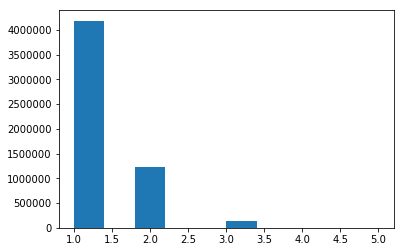

In [4]:
plt.hist(customer_df.qcgp_cnt)

In [5]:
customer_df.to_csv('customer_df.csv',index=False)

In [6]:
customer_df = pd.read_csv('customer_df.csv')
customer_df.head(3)

,customer_id,query_cnt,file_cnt,pos_cnt,mean_code,tr_cnt,dg_score,qcgp_cnt
0,0000006fa286976bf35ea17f1f19bc7a,2,1,0.0,0.0,1.0,1.0,1.0
1,00000145d9062eada528bace5fb4864e,3,2,0.0,0.0,2.0,1.0,1.0
2,000003d77bee692d83b7b83fdba60d3d,24,24,0.0,0.0,24.0,1.0,2.0


In [7]:
customer_df = customer_df[['customer_id','qcgp_cnt']]
customer_df.head(3)

,customer_id,qcgp_cnt
0,0000006fa286976bf35ea17f1f19bc7a,1.0
1,00000145d9062eada528bace5fb4864e,1.0
2,000003d77bee692d83b7b83fdba60d3d,2.0


In [8]:
data.head(3)

,customer_id,file_id,query_cnt,target
0,0000006fa286976bf35ea17f1f19bc7a,f096e1c6e0cbaf10389fbf427b4d341f,2,0.0
1,00000145d9062eada528bace5fb4864e,19308434813502167aaef38f578981a4,1,0.0
2,00000145d9062eada528bace5fb4864e,ee6a1280be5c96d7b2461de6b7578180,2,0.0


In [9]:
data = pd.merge(data,customer_df,how='left',on='customer_id')
data.head(3)

,customer_id,file_id,query_cnt,target,qcgp_cnt
0,0000006fa286976bf35ea17f1f19bc7a,f096e1c6e0cbaf10389fbf427b4d341f,2,0.0,1.0
1,00000145d9062eada528bace5fb4864e,19308434813502167aaef38f578981a4,1,0.0,1.0
2,00000145d9062eada528bace5fb4864e,ee6a1280be5c96d7b2461de6b7578180,2,0.0,1.0


In [10]:
data = data.groupby(['file_id','qcgp_cnt']).count().reset_index()
data = data[['file_id','qcgp_cnt','customer_id']]
data.columns = ['file_id','qcgp_cat','qcgp_cnt']
data.head(3)

,file_id,qcgp_cat,qcgp_cnt
0,00008c73ee43c15b16c26b26398c1577,1.0,78
1,00008c73ee43c15b16c26b26398c1577,2.0,12
2,00008c73ee43c15b16c26b26398c1577,5.0,1


In [11]:
data = data.pivot_table(values='qcgp_cnt',index=['file_id'],columns='qcgp_cat',aggfunc='sum').reset_index()
data.head(3)

qcgp_cat,file_id,1.0,2.0,3.0,4.0,5.0
0,00008c73ee43c15b16c26b26398c1577,78.0,12.0,NaN,NaN,1.0
1,0000e2398b12121a85166fed5fe2a3da,1.0,2.0,NaN,NaN,NaN
2,0001fe8dce14ce099aa6ca8ea5026ea7,7.0,165.0,61.0,1.0,NaN


In [12]:
data.to_csv('qcgp_feat.csv',index=False)

In [13]:
data=pd.read_csv('qcgp_feat.csv')
data.head(3)

,file_id,1.0,2.0,3.0,4.0,5.0
0,00008c73ee43c15b16c26b26398c1577,78.0,12.0,NaN,NaN,1.0
1,0000e2398b12121a85166fed5fe2a3da,1.0,2.0,NaN,NaN,NaN
2,0001fe8dce14ce099aa6ca8ea5026ea7,7.0,165.0,61.0,1.0,NaN


In [14]:
data.columns = ['file_id','qcgp1','qcgp2','qcgp3','qcgp4','qcgp5']
data.head(3)

,file_id,qcgp1,qcgp2,qcgp3,qcgp4,qcgp5
0,00008c73ee43c15b16c26b26398c1577,78.0,12.0,NaN,NaN,1.0
1,0000e2398b12121a85166fed5fe2a3da,1.0,2.0,NaN,NaN,NaN
2,0001fe8dce14ce099aa6ca8ea5026ea7,7.0,165.0,61.0,1.0,NaN


In [16]:
data.iloc[:,1:]

,qcgp1,qcgp2,qcgp3,qcgp4,qcgp5
0,78.0,12.0,NaN,NaN,1.0
1,1.0,2.0,NaN,NaN,NaN
2,7.0,165.0,61.0,1.0,NaN
3,9.0,10.0,2.0,NaN,1.0
4,2.0,77.0,33.0,NaN,1.0
5,NaN,NaN,2.0,2.0,1.0
6,39.0,80.0,10.0,NaN,1.0
7,NaN,5.0,6.0,NaN,1.0
8,33.0,454.0,126.0,1.0,NaN
9,6.0,2.0,4.0,NaN,1.0


In [17]:
data.fillna(0,inplace=True)
data['qcgpsum'] = data.iloc[:,1:].sum(axis=1)
data['qcgp1p'] = data['qcgp1'] / data['qcgpsum']
data['qcgp2p'] = data['qcgp2'] / data['qcgpsum']
data['qcgp3p'] = data['qcgp3'] / data['qcgpsum']
data['qcgp4p'] = data['qcgp4'] / data['qcgpsum']
data['qcgp5p'] = data['qcgp5'] / data['qcgpsum']
data.drop('qcgpsum',axis=1,inplace=True)
data.head(3)

,file_id,qcgp1,qcgp2,qcgp3,qcgp4,qcgp5,qcgp1p,qcgp2p,qcgp3p,qcgp4p,qcgp5p
0,00008c73ee43c15b16c26b26398c1577,78.0,12.0,0.0,0.0,1.0,0.857143,0.131868,0.000000,0.000000,0.010989
1,0000e2398b12121a85166fed5fe2a3da,1.0,2.0,0.0,0.0,0.0,0.333333,0.666667,0.000000,0.000000,0.000000
2,0001fe8dce14ce099aa6ca8ea5026ea7,7.0,165.0,61.0,1.0,0.0,0.029915,0.705128,0.260684,0.004274,0.000000


In [18]:
data.to_csv('qcgp_feat.csv',index=False)